# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")

import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import bar_samples as bs
import bar_labels as bl
import bar_workflow as bw
import utils_filters as ft
from utils_pickle import pickle_dump, pickle_load

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# set sampling params

# Sample tick dates

In [2]:
# set sampling params
symbol = 'VTI'
start_date = '2020-04-01'
end_date = '2020-04-05'

thresh = {
    # mad filter
    'mad_value_winlen': 11,
    'mad_k': 22,    
    'mad_deviation_winlen': 333,     
    # jma filter
    'jma_winlen': 7,
    'jma_power': 2,
    # bar thresholds
    'renko_return': 'jma_return',
    'renko_size': 0.11,
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'label_reward_ratios': list(np.arange(2.5, 11, 0.5)),
}

In [ ]:
# bar dates workflow

bar_dates = bw.bar_dates_workflow(symbol, start_date, end_date, thresh, ray_on=True)

In [ ]:
bdf = pd.DataFrame(bar_dates[3]['bars'])
tdf = bar_dates[3]['ticks_df']

# fill daily gaps
stacked_df = bw.fill_gaps_dates(bar_dates, fill_col='jma_wmean')

# stacked stats
stats_df = bw.stacked_df_stats(stacked_df)

In [3]:
# bar workflow

bar_date = bw.bar_workflow(symbol, date='2020-11-19', thresh=thresh, add_label=True)

tdf = bar_date['ticks_df']
bdf = pd.DataFrame(bar_date['bars'])

VTI 2020-11-19 trying to get data from local file...


/Users/bobcolner/QuantClarity/pandas-polygon/bar_workflow.py:165: UserWarning: Discarding nonzero nanoseconds in conversion
  ft_tick = filter_tick(tick, mad_filter, jma_filter, tick_rule, bar_sampler)


Dropping label, only 22 trades;start at: 2020-11-19 15:59:50.239149824-05:00


<AxesSubplot:xlabel='close_at'>

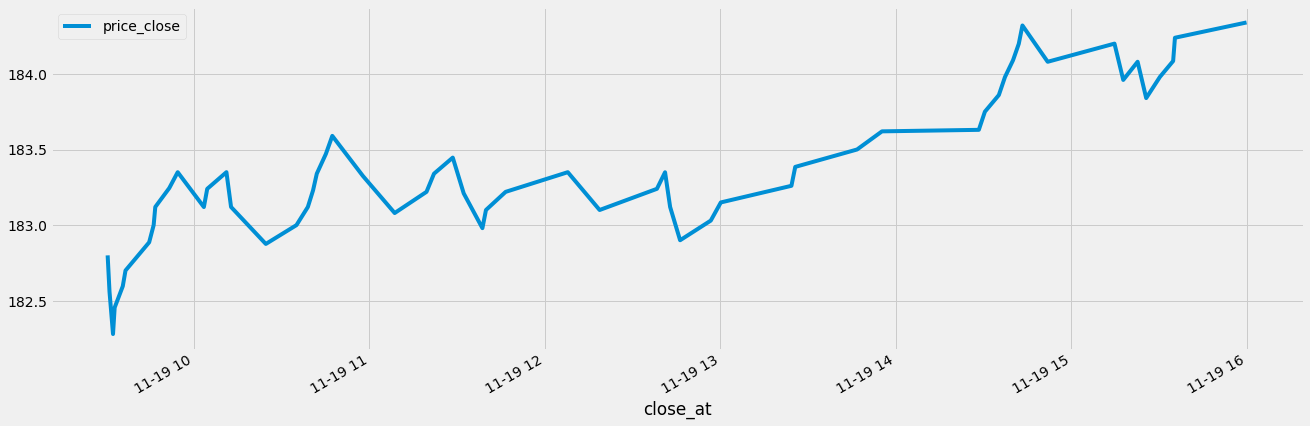

In [9]:
bdf.plot(x='close_at', y='price_close')

In [5]:
abs(bdf.label_rrr).value_counts()/bdf.shape[0]

0.000000   0.423729
3.000000   0.135593
3.500000   0.101695
4.500000   0.084746
4.000000   0.067797
2.500000   0.050847
5.500000   0.050847
6.000000   0.033898
5.000000   0.016949
8.000000   0.016949
Name: label_rrr, dtype: float64

<AxesSubplot:>

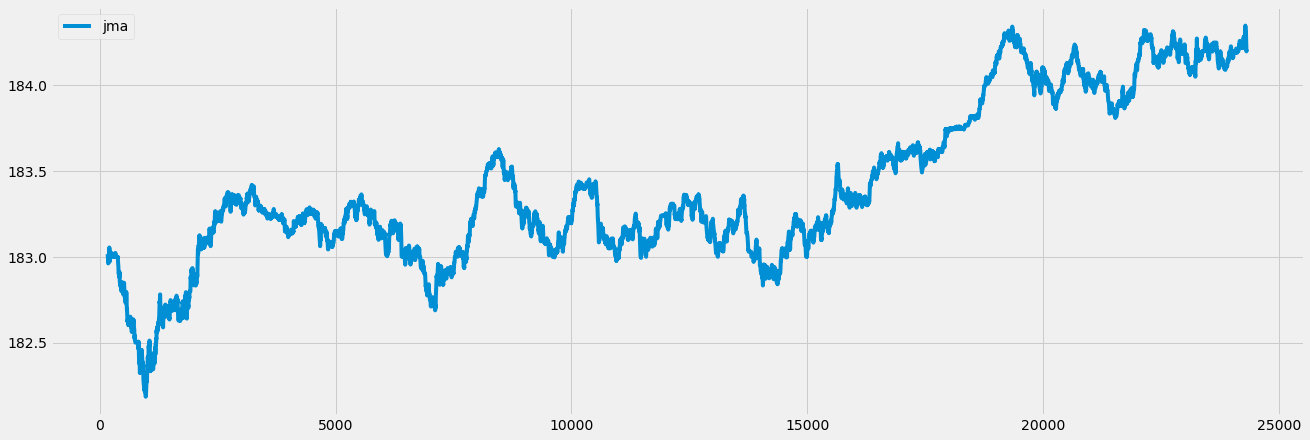

In [6]:
tdf[tdf.status.str.startswith('clean_open_mar')].plot(y='jma')

<AxesSubplot:xlabel='nyc_time'>

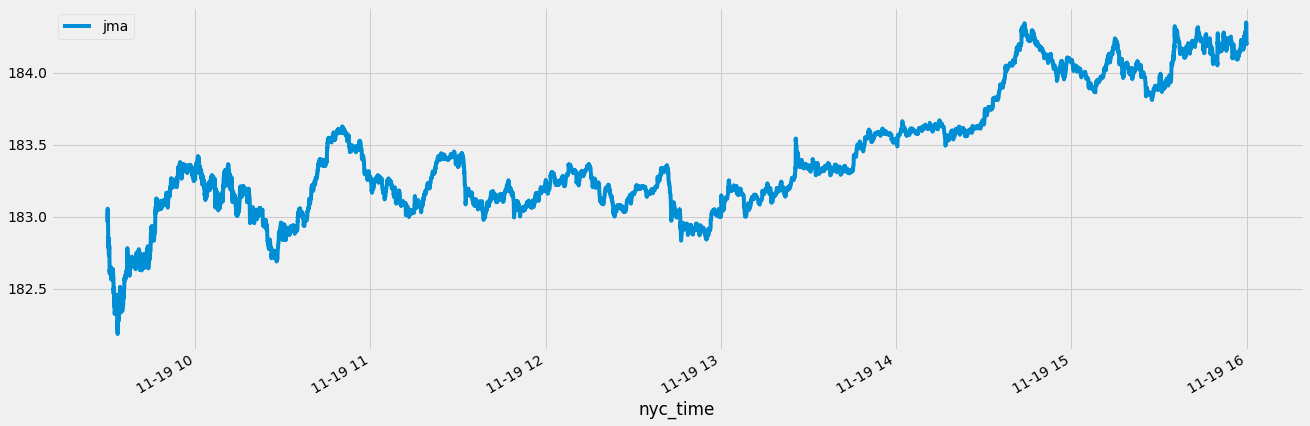

In [7]:
tdf[tdf.status.str.startswith('clean_open_mar')].plot(x='nyc_time', y='jma')

In [ ]:
# fetch and build bars

ticks_df = ps3.fetch_date_df(symbol, date='2020-11-19', tick_type='trades')

bars, tdf = bw.build_bars(ticks_df, thresh)

bdf = pd.DataFrame(bars)

In [ ]:
bdf.plot(y='jma_wmean')

In [ ]:
bdf.plot(x='close_at', y='jma_wmean')

In [ ]:
results = []

for date in bar_dates:
    out = (date['ft_ticks_df'].status.value_counts() / date['ft_ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)

pd.DataFrame(results)

In [ ]:
# rw, outlier_ind = ft.random_walk_with_outliers(0, 1000, 0.01)
# plt.plot(np.arange(len(rw)), rw)
# plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
# plt.title('Random Walk with outliers')
# plt.xlabel('Time steps')
# plt.ylabel('Values')
# plt.legend();

from bokeh.plotting import figure, output_file, show, output_notebook
# output_notebook()

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p1 = figure(title="Legend Example", tools=TOOLS)
p1.line(df.index, df.price)
p1.circle(df[df.mad_outlier==True].index, df[df.mad_outlier==True].price, legend_label="outlier", color="orange")

# output_file("legend.html", title="legend.py example")
show(p1, sizing_mode="scale_height")  # open a browser
